In [20]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib as plt
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv('merged_output.csv')

In [4]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1.0,0.0,1.0,...,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0.0,0.0,0.0,...,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0.0,0.0,0.0,...,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0.0,1.0,0.0,...,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


In [7]:
df.describe()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
count,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,...,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000,46686579.000
mean,5.765,76705.964,9.066,66.351,9064.057,9064.057,0.000,0.087,0.207,0.091,...,124.669,33.325,124.692,83182525.866,9.498,13.122,47.095,30724.357,0.096,141.512
std,285.034,461331.747,8.946,14.019,99562.491,99562.491,0.007,0.281,0.405,0.287,...,240.991,160.336,241.549,17047351.735,0.819,8.629,226.770,323710.680,0.233,21.068
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,42.000,0.000,42.000,0.000,1.000,9.165,0.000,0.000,0.000,1.000
25%,0.000,54.000,6.000,64.000,2.092,2.092,0.000,0.000,0.000,0.000,...,50.000,0.000,50.000,83071565.967,9.500,10.000,0.000,0.000,0.000,141.550
50%,0.000,54.000,6.000,64.000,15.754,15.754,0.000,0.000,0.000,0.000,...,54.000,0.000,54.000,83124522.404,9.500,10.392,0.000,0.000,0.000,141.550
75%,0.105,280.555,14.330,64.000,117.385,117.385,0.000,0.000,0.000,0.000,...,54.050,0.372,54.060,83343907.954,9.500,10.397,0.506,1.344,0.080,141.550
max,394357.207,9907147.750,47.000,255.000,8388608.000,8388608.000,29.715,1.000,1.000,1.000,...,13583.000,12385.239,13583.000,167639436.042,15.000,164.821,17551.271,154902159.248,1.000,244.600


In [5]:
class_counts = df['label'].value_counts()
print(class_counts)



label
DDoS-ICMP_Flood            7200504
DDoS-UDP_Flood             5412287
DDoS-TCP_Flood             4497667
DDoS-PSHACK_Flood          4094755
DDoS-SYN_Flood             4059190
DDoS-RSTFINFlood           4045285
DDoS-SynonymousIP_Flood    3598138
DoS-UDP_Flood              3318595
DoS-TCP_Flood              2671445
DoS-SYN_Flood              2028834
BenignTraffic              1098195
Mirai-greeth_flood          991866
Mirai-udpplain              890576
Mirai-greip_flood           751682
DDoS-ICMP_Fragmentation     452489
MITM-ArpSpoofing            307593
DDoS-UDP_Fragmentation      286925
DDoS-ACK_Fragmentation      285104
DNS_Spoofing                178911
Recon-HostDiscovery         134378
Recon-OSScan                 98259
Recon-PortScan               82284
DoS-HTTP_Flood               71864
VulnerabilityScan            37382
DDoS-HTTP_Flood              28790
DDoS-SlowLoris               23426
DictionaryBruteForce         13064
BrowserHijacking              5859
CommandInjecti

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler

features = df.drop('label', axis=1)
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
scaled_df = pd.concat([scaled_features, df['label']], axis=1)

del df

scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46686579 entries, 0 to 46686578
Data columns (total 47 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flow_duration    float64
 1   Header_Length    float64
 2   Protocol Type    float64
 3   Duration         float64
 4   Rate             float64
 5   Srate            float64
 6   Drate            float64
 7   fin_flag_number  float64
 8   syn_flag_number  float64
 9   rst_flag_number  float64
 10  psh_flag_number  float64
 11  ack_flag_number  float64
 12  ece_flag_number  float64
 13  cwr_flag_number  float64
 14  ack_count        float64
 15  syn_count        float64
 16  fin_count        float64
 17  urg_count        float64
 18  rst_count        float64
 19  HTTP             float64
 20  HTTPS            float64
 21  DNS              float64
 22  Telnet           float64
 23  SMTP             float64
 24  SSH              float64
 25  IRC              float64
 26  TCP              float64
 27  UDP       

In [11]:
remap_labels = {
    'DDoS-RSTFINFlood': 'DDoS-Flood',
    'DDoS-PSHACK_Flood': 'DDoS-Flood',
    'DDoS-SYN_Flood': 'DDoS-Flood',
    'DDoS-UDP_Flood': 'DDoS-Flood',
    'DDoS-TCP_Flood': 'DDoS-Flood',
    'DDoS-ICMP_Flood': 'DDoS-Flood',
    'DDoS-SynonymousIP_Flood': 'DDoS-FRAG',
    'DDoS-ACK_Fragmentation': 'DDoS-FRAG',
    'DDoS-UDP_Fragmentation': 'DDoS-FRAG',
    'DDoS-ICMP_Fragmentation': 'DDoS-FRAG',
    'DDoS-SlowLoris': 'DDoS-Flood',
    'DDoS-HTTP_Flood': 'DDoS-Flood',
    'DoS-UDP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-greip_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    'Recon-PingSweep': 'Recon',
    'Recon-OSScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon',
    'Recon-HostDiscovery': 'Recon',
    'DNS_Spoofing': 'Spoofing',
    'MITM-ArpSpoofing': 'Spoofing',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Web-Based',
    'Backdoor_Malware': 'Web-Based',
    'XSS': 'Web-Based',
    'Uploading_Attack': 'Web-based',
    'SqlInjection': 'Web-based',
    'CommandInjection': 'Web-based',
    'DictionaryBruteForce': 'Brute-Force'
}

scaled_df['label'] = scaled_df['label'].apply(lambda x : remap_labels[x])

scaled_df['label'].value_counts()

label
DDoS-Flood     29361904
DoS             8090738
DDoS-FRAG       4622656
Mirai           2634124
Benign          1098195
Spoofing         486504
Recon            354565
Brute-Force       13064
Web-Based         12923
Web-based         11906
Name: count, dtype: int64

In [12]:
# selecting n samples from each class for balancing
n = 50000
sampled_df = scaled_df.groupby('label', group_keys=False).apply(lambda x: x.head(n))

sampled_df.value_counts('label')

label
Benign         50000
DDoS-FRAG      50000
DDoS-Flood     50000
DoS            50000
Mirai          50000
Recon          50000
Spoofing       50000
Brute-Force    13064
Web-Based      12923
Web-based      11906
Name: count, dtype: int64

In [13]:
if sampled_df['label'].nunique() > 1:
    X = sampled_df.drop('label', axis=1)
    y = sampled_df['label']

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    resampled_df['label'] = y_resampled
else:
    print("Requires more than one target category for SMOTE")


In [15]:
#Assign random oversampling for features will less than n observations for balancing
ros = RandomOverSampler(random_state=42)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X, y)
print(pd.Series(y_resampled_ros).value_counts())

label
Benign         50000
Brute-Force    50000
DDoS-FRAG      50000
DDoS-Flood     50000
DoS            50000
Mirai          50000
Recon          50000
Spoofing       50000
Web-Based      50000
Web-based      50000
Name: count, dtype: int64


In [17]:
#Enconding labels for better performance. Remapping to numeric from char.
label_encoder = LabelEncoder()
resampled_df['label'] = label_encoder.fit_transform(resampled_df['label'])
#Total of 10 labels, index start at 0:9
resampled_df.value_counts('label')

label
0    50000
1    50000
2    50000
3    50000
4    50000
5    50000
6    50000
7    50000
8    50000
9    50000
Name: count, dtype: int64

In [18]:
#Splitting data into test and training subsets
x_train, x_test, y_train, y_test = train_test_split(resampled_df.drop('label', axis=1), resampled_df['label'], test_size=0.2, random_state=42)

In [25]:
#RandomForest model
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto','sqrt'],
    'bootstrap': [True]
}


grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy',verbose=2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_best = best_model.predict(x_test)

# Evaluate the performance of the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy of the best model:", accuracy_best)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators

C:\Users\RyanM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
81 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\RyanM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\RyanM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pac

Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy of the best model: 0.93533


In [1]:

import joblib

# Save the best model to a file
joblib.dump(best_model, '/Desktop/wataiData/best_random_forest_model.pkl')


NameError: name 'best_model' is not defined

Variable Importance:
flow_duration: 0.050407379307360806
Header_Length: 0.057338676199290964
Protocol Type: 0.037872935285483716
Duration: 0.024615489094265697
Rate: 0.02847215119520987
Srate: 0.026840898392757873
Drate: 3.372759744885793e-07
fin_flag_number: 0.0017037818251770902
syn_flag_number: 0.016048936268724702
rst_flag_number: 0.0013442334573291928
psh_flag_number: 0.002736608744118099
ack_flag_number: 0.006093491817089001
ece_flag_number: 3.0575394412537543e-06
cwr_flag_number: 2.857210503351188e-06
ack_count: 0.010802388848994302
syn_count: 0.04026082740001251
fin_count: 0.013565125751123865
urg_count: 0.041258343453612616
rst_count: 0.04913218071232425
HTTP: 0.00491257569259627
HTTPS: 0.0076221887696660984
DNS: 0.00016464602285250657
Telnet: 0.0
SMTP: 0.0
SSH: 0.007561801862843976
IRC: 0.0
TCP: 0.00825092523071309
UDP: 0.005104284603158955
DHCP: 0.0
ARP: 4.7721035655717466e-05
ICMP: 0.0032727159790388585
IPv: 0.00011167299141080227
LLC: 0.00010297701373622573
Tot sum: 0.0287

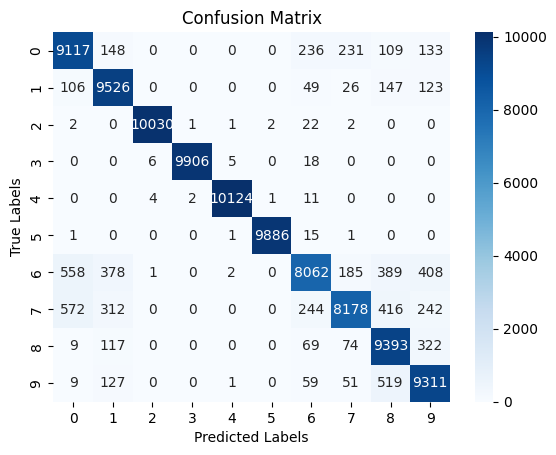

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_best = best_model.predict(x_test)

# Variable Importance
feature_importances = best_model.feature_importances_
print("Variable Importance:")
for feature, importance in zip(x_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [30]:
import shap

# Assume 'best_model' is your trained RandomForest model
# and 'x_test' is your test dataset

# Create an explainer for the RandomForest model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(x_test)

# Create a summary plot
shap.summary_plot(shap_values, x_test, plot_type="bar")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


: 